In [246]:
# imports
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

from os import listdir
from os.path import isfile, join
from datetime import datetime
from matplotlib.colors import LogNorm
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

from astropy.wcs import WCS
import astropy
from astropy.coordinates import SkyCoord 
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs.utils import pixel_to_skycoord

from scipy.optimize import curve_fit
plt.rcParams.update({'font.size': 12})

from os import listdir
from os.path import isfile, join
from datetime import datetime
from matplotlib.colors import LogNorm

from photutils.centroids import centroid_2dg

import warnings
warnings.filterwarnings('ignore')

file_names = 'AST325-326-SN-filelist.txt'



# refrence stars
ref_star1 = SkyCoord('00h56m49.70s', '-37d01m38.31s') # 16.32 \pm 0.07 Magnitude
ref_star2 = SkyCoord('00h56m46.43s', '-37d02m29.50s') #17.16 \pm 0.08
ref_star3 = SkyCoord('00h56m58.27s', '-36d58m16.60s') # 15.61 \pm 0.02

In [13]:
# read in file containing file names
file_names = np.genfromtxt(fname=file_names, dtype=str)

In [14]:
file_names[0]

'AST325-326-SN-20150920.9181.fits'

In [15]:
# we need to open up 1 test file
# we need to make a function that cuts out boxes, centers and determines flux
# of refrence stars

# measure flux and SNR of SN

In [ ]:
# a function for fitting a 2d gaussian, and return fitted x, y, and sx sy

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()


    
    
    
    


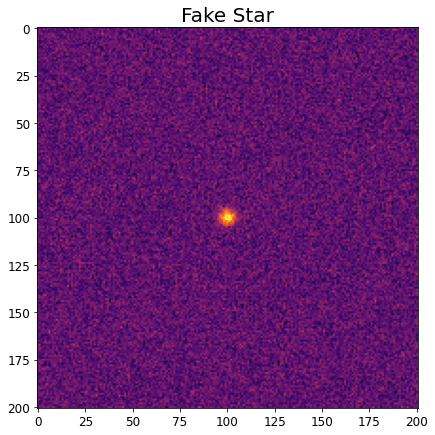

[96.55214137 99.96765246  3.37448221 19.46809951]


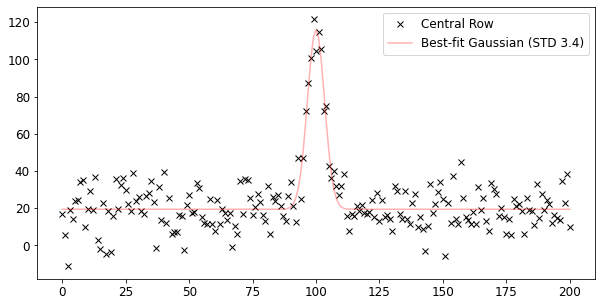

In [276]:
# for finding star radius 
def two_d_gaussian(x,y,ux,uy,sx,sy,A):
    return A*np.exp(-1*((x-ux)**2/(2*sx**2) + (y-uy)**2/(2*sy**2)))
# u is mean
# s is sigma

def gaus(x,a,x0,sigma, c):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + c

def fake_star(amplitude, noise):
    axis = np.arange(-100,101).astype(float)
    x,y = np.meshgrid(axis,axis)
    
    data = np.zeros_like(x)

    data += two_d_gaussian(x,y,0,0,3,3,amplitude)
    
    return data + np.random.normal(0, noise, x.shape) + 20

amp = 100
star = fake_star(amp, 10)
plt.figure(figsize=(7,7))
plt.imshow(star, cmap = 'inferno')
plt.title("Fake Star", size = 20)
plt.show()

#Now we can fit a Gaussian to the star image
x, y = np.arange(star.shape[0]), star[star.shape[0]//2,:]
popt, pcov = curve_fit(gaus,
                       x,y,
                       p0=[amp,star.shape[0]//2,10, 0])
print(popt)
plt.figure(figsize=(10,5))
plt.plot(x,y, 'x', color = 'k', label = 'Central Row')
plt.plot(x,gaus(x,*popt),color = 'r', alpha = 0.3, label = f'Best-fit Gaussian (STD {round(popt[2],1)})')
plt.legend()
plt.show()

In [21]:
r_ap = 3.5 #* std of guassian fit 

NameError: name 'ls' is not defined

In [160]:
np.shape(star)

(201, 201)

In [27]:
#get all of the files 
img_files = [f for f in listdir('.') if isfile(join('.', f)) and 'fits' in f]

img_files = file_names
file_times = []
for f in img_files:
    f = 'AST325-326-SN/' + f 
    header = fits.open(f)[0].header
    dt = datetime.fromisoformat(header["DATE-OBS"])
    file_times.append(dt)

#sort files by the same way
file_times, img_files = zip(*sorted(zip(file_times, img_files)))

img_files = np.array(img_files)
file_times = np.array(file_times)

print(img_files[:10])
print(file_times[:10])

['AST325-326-SN-20150920.9181.fits' 'AST325-326-SN-20150920.9361.fits'
 'AST325-326-SN-20150920.9535.fits' 'AST325-326-SN-20150922.1458.fits'
 'AST325-326-SN-20150922.1618.fits' 'AST325-326-SN-20150922.1757.fits'
 'AST325-326-SN-20150922.1924.fits' 'AST325-326-SN-20150922.2083.fits'
 'AST325-326-SN-20150922.2243.fits' 'AST325-326-SN-20150922.2410.fits']
[datetime.datetime(2015, 9, 20, 22, 2, 14)
 datetime.datetime(2015, 9, 20, 22, 28, 10)
 datetime.datetime(2015, 9, 20, 22, 53, 57)
 datetime.datetime(2015, 9, 22, 3, 30, 17)
 datetime.datetime(2015, 9, 22, 3, 53, 5)
 datetime.datetime(2015, 9, 22, 4, 13, 38)
 datetime.datetime(2015, 9, 22, 4, 37, 45)
 datetime.datetime(2015, 9, 22, 5, 0, 6)
 datetime.datetime(2015, 9, 22, 5, 23, 39)
 datetime.datetime(2015, 9, 22, 5, 47, 5)]


In [193]:
# put ra, dec of ref stars into sky coordinate objects 
ref_stars = [ref_star1, ref_star2, ref_star3]

def read_file(f):
    fits_file = 'AST325-326-SN/' + f 
    
    # open fits file and returns data, header
    with fits.open(fits_file) as hdul:
        #hdul.info()
        hdr = hdul[0].header
        fits_data = hdul[0].data
    
    return fits_data, hdr
    
   

[<SkyCoord (ICRS): (ra, dec) in deg
    (14.20708333, -37.02730833)>, <SkyCoord (ICRS): (ra, dec) in deg
    (14.19345833, -37.04152778)>, <SkyCoord (ICRS): (ra, dec) in deg
    (14.24279167, -36.97127778)>]


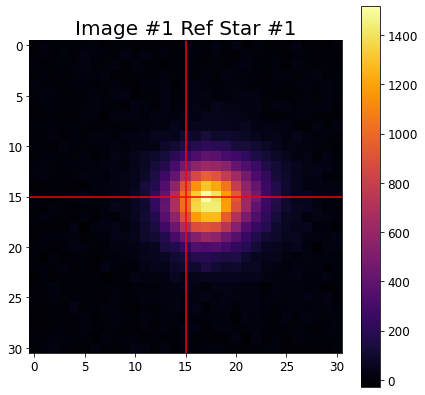

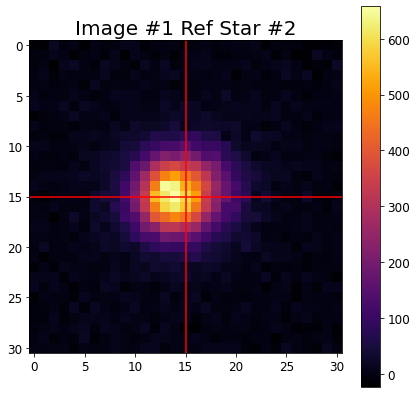

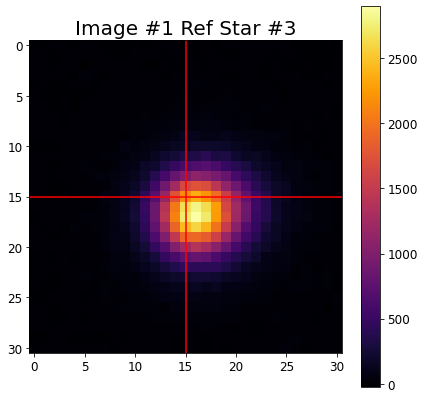

In [286]:
#I put the reference star positions from the lab into Sky Coordinate objects in astropy
print(ref_stars) 

boxsize = 15

#To start, lets loops through each image and read it (we will only do the first few)
#For image in images 
for i, f in enumerate(img_files[:1]):
    
    # read the image
    data, header  = read_file(f)
    # use the fits header information for cordinate transformations
    w = WCS(header)
    
#In each image, we want to find the position of each star
    for j, star in enumerate(ref_stars):
        
        # locate the star
        ref_pos = skycoord_to_pixel(star, w)
        ref_x, ref_y = ref_pos
        
        # we can then put look at a box around the star to set up our flux code above
        ref_x_int, ref_y_int = ref_x.astype(int), ref_y.astype(int)

        #generate region around star
        sub_im = data[ref_y_int-boxsize: ref_y_int+boxsize+1, 
                      ref_x_int-boxsize: ref_x_int+boxsize+1]
        plt.figure(figsize=(7,7))
        plt.imshow(sub_im, cmap = 'inferno',interpolation = "None")
        plt.title(f"Image #{i+1} Ref Star #{j+1}", size = 20)
        plt.axvline(x = sub_im.shape[0]//2, color = 'red')
        plt.axhline(y = sub_im.shape[0]//2, color = 'red')
        plt.colorbar()
        plt.show()
    
    

Original Centroid (3.789687792339322, 0.47888046317016375)
centroid location
1536 1242
New Centroid (-2.0148150290427225, 0.47136514875319335)


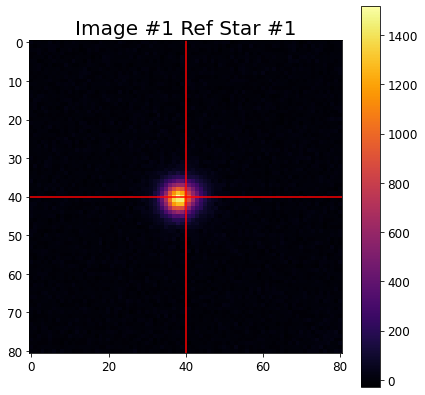

my r  15


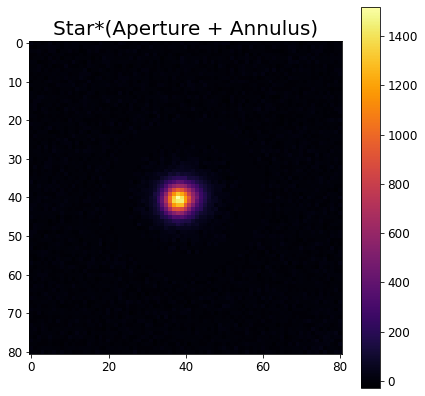

Original Centroid (-1.6422403273785662, -0.30401400272826606)
centroid location
1632 1114
New Centroid (2.4857020687364084, -0.3359792292168038)


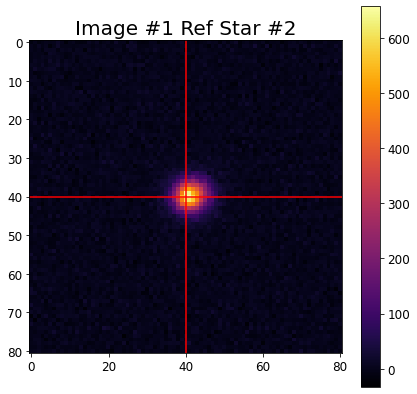

my r  15


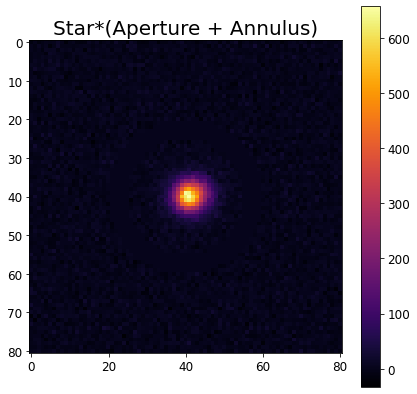

Original Centroid (1.8490582920135878, 1.996256372838367)
centroid location
1265 1749
New Centroid (-0.5412868705707155, -0.4294016828023146)


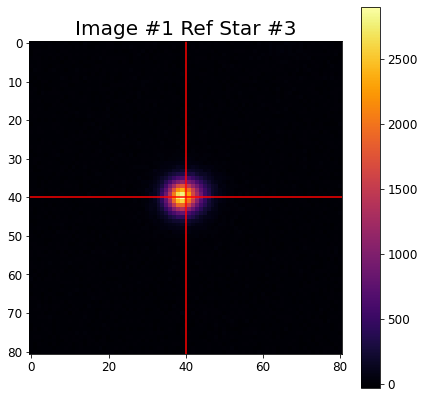

my r  15


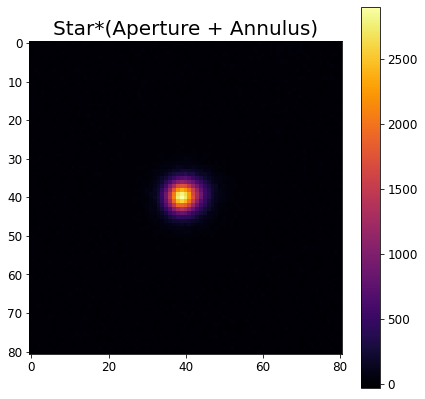

In [287]:
#Repeating the code from above
boxsize = 40

for i, f in enumerate(img_files[:1]):
    
    data, header  = read_file(f)
    w = WCS(header)
    
    for j, star in enumerate(ref_stars):
        
        ref_pos = skycoord_to_pixel(star, w)
        ref_x, ref_y = ref_pos
        ref_x_int, ref_y_int = ref_x.astype(int), ref_y.astype(int)
        sub_im = data[ref_y_int-boxsize: ref_y_int+boxsize+1, 
                      ref_x_int-boxsize: ref_x_int+boxsize+1]
        
        #I wrote a function to compute the centroid relative to the center of the sub image
        centroid = my_centroid(sub_im)
        print("Original Centroid", centroid)
        
        #Notice that the centroid is not at a pixel interval,
        #we should be fine shifting the image as best we can
        sub_im = center_image(data, sub_im, ref_pos)
        new_centroid = my_centroid(sub_im)
        print("New Centroid", new_centroid)
        
        plt.figure(figsize=(7,7))
        plt.imshow(sub_im, cmap = 'inferno',interpolation = "None")
        plt.title(f"Image #{i+1} Ref Star #{j+1}", size = 20)
        plt.axvline(x = sub_im.shape[0]//2, color = 'red')
        plt.axhline(y = sub_im.shape[0]//2, color = 'red')
        plt.colorbar()
        plt.show()
        
        aperture = get_aperture(sub_im)
        annulus = get_annulus(sub_im)
        
        plt.figure(figsize=(7,7))
        plt.imshow(sub_im*(annulus + aperture), cmap = 'inferno',interpolation = "None")
        plt.title("Star*(Aperture + Annulus)", size = 20)
        plt.colorbar()
        plt.show()
    

In [63]:
# 12-15 days

my_arr = np.ones((10,10))

np.shape(my_arr)

(10, 10)

In [331]:
#centroid = ta.centroid(sub_im)

def my_centroid(sub_im):
    # fits a 2d gaussian over the sub image and returns the pixel values of the
    # cetener reletive to the sub_image
    
    c_x, c_y = centroid_2dg(sub_im)
    
    # I think the difference is because Jacob is using a different method for the
    # 2d center
    return c_x - boxsize, c_y - boxsize 

def center_image(data, sub_im, ref_pos):
    # cuts out a better sub_im of the data
    # we can use ref_positon to center and then
    
    ref_x, ref_y = ref_pos
    
    c_x, c_y = my_centroid(sub_im) # relative to sub image 
    
    pix_x = int(ref_x + c_x)  
    pix_y = int(ref_y + c_y) 
    
    new_sub_im = np.empty(np.shape(sub_im))
    print('centroid location')
    print(pix_x, pix_y)

    
    #pix_x -= int(2*len(x))
    #pix_y -= int(2*len(y))
    
    # I think I must be taking the wrong 
    new_sub_im = data[pix_y-boxsize: pix_y+boxsize+1, pix_x-boxsize:pix_x+boxsize+1]
    
    return new_sub_im

#Original Centroid [0.40977778 2.3821601 ]
#New Centroid [0.40860909 0.40873871]

#sub_im = ta.center_image(data, sub_im, ref_pos)

#new_centroid = ta.centroid(sub_im)

In [280]:
#aperture = ta.get_aperture(sub_im.shape, 12)
#annulus = ta.get_annulus(sub_im.shape, 20, 40)
from scipy.stats import norm

def get_aperture(sub_im, multi=3.5):
    '''fits a circle on the star with radius = r^2 = sx^2 + sy^2'''
    
    # measure std along one axis
    middlex = int(np.shape(sub_im)[1] / 2)
    sx = np.std(sub_im[:,middlex])
    
    
    middley = int(np.shape(sub_im)[0] / 2)
    sy = np.std(sub_im[middley,:])
    
    r = np.sqrt(sx**2 + sy**2)
    my_r = multi *r 
    
    
    #print(3*r)
    
    my_r = 12
    
    mu, std = norm.fit(data)
    
    #my_r = multi * std
    my_r = 15
    print('my r ', my_r)
    aperture = np.zeros(np.shape(sub_im))
    
    center = middlex, middley
    
    for i in range(int(np.shape(sub_im)[0])):
                   for j in range(int(np.shape(sub_im)[0])):
                         if (i-middlex)**2 + (j-middley)**2 < my_r**2:
                                  aperture[i,j] = 1
    
    return aperture.astype(int)


def get_annulus(sub_im, inner=9, outer=24):
    
    # measure std along one axis
    middlex = int(np.shape(sub_im)[1] / 2)
    sx = np.std(sub_im[:,middlex])
    
    middley = int(np.shape(sub_im)[0] / 2)
    sy = np.std(sub_im[middley,:])
    
    r = np.sqrt(sx**2 + sy**2)
    #inner_r = inner *std
    #outer_r = outer * std
    
    inner_r = 20
    outer_r = 60
    
   # mu, std = norm.fit(data)
    #inner_r = inner *std
    #outer_r = outer * std
    
    annulus = np.zeros(np.shape(sub_im), )
    
    center = middlex, middley
    
    for i in range(int(np.shape(sub_im)[0])):
                   for j in range(int(np.shape(sub_im)[0])):
                         if (i-middlex)**2 + (j-middley)**2 > inner_r**2:
                            if (i-middlex)**2 + (j-middley)**2 < outer_r**2:
                                  annulus[i,j] = 1
                                    
      # float_array.astype(int)                             
    return annulus.astype(int)
    

In [263]:
1 == True

True

In [281]:
#The easiest way to compute flux is to generate binary masks for the aperture and annulus
aperture = get_aperture(star)
annulus = get_annulus(star)

plt.figure(figsize=(7,7))
plt.imshow(aperture, cmap = 'inferno',interpolation = "None")
plt.title("Aperture", size = 20)
plt.colorbar()
plt.show()

plt.figure(figsize=(7,7))
plt.imshow(annulus, cmap = 'inferno',interpolation = "None")
plt.title("Annulus", size = 20)
plt.colorbar()
plt.show()

plt.figure(figsize=(7,7))
plt.imshow(annulus + aperture, cmap = 'inferno',interpolation = "None")
plt.title("Aperture + Annulus", size = 20)
plt.colorbar()
plt.show()

plt.figure(figsize=(7,7))
plt.imshow(star*(annulus + aperture), cmap = 'inferno',interpolation = "None")
plt.title("Star*(Aperture + Annulus)", size = 20)
plt.colorbar()
plt.show()

IndexError: tuple index out of range

In [288]:
def get_flux(sub_im, aperture, annulus):
    
    # calculates flux of star in the aperture
    
    # calculate background noise per pixel
    
    #background = np.sum(sub_im[annulus]) / np.sum(annulus)
    
    background = np.sum(sub_im * annulus) / np.sum(annulus)
    
    #flux = np.sum(sub_im[aperture] -background)
    
    flux = np.sum((sub_im * aperture) - background)
    
    return flux

In [289]:
#Repeating the code from above
boxsize = 30

# why is it 100 - boxsize? we are centering 100?

sub_im = data[100-boxsize: 100+boxsize+1, 100-boxsize: 100+boxsize+1]

#Create an aperture and annulus model
aperture = get_aperture(sub_im)
annulus = get_annulus(sub_im)

fluxes = np.empty((len(ref_stars),len(img_files)))

for i, f in enumerate(img_files):
    
    data, header  = read_file(f)
    w = WCS(header)
    
    for j, star in enumerate(ref_stars):
        ref_pos = skycoord_to_pixel(star, w)
        ref_x, ref_y = ref_pos
        print('refrence ')
        print(ref_x, ref_y)
        ref_x_int, ref_y_int = ref_x.astype(int), ref_y.astype(int)
        sub_im = data[ref_y_int-boxsize: ref_y_int+boxsize+1, 
                      ref_x_int-boxsize: ref_x_int+boxsize+1]
        sub_im = center_image(data, sub_im, ref_pos)
        
        #Get the flux for each of the reference stars 
        fluxes[j,i] = get_flux(sub_im, aperture, annulus)
        


my r  15
refrence 
1532.7993922131163 1242.2382688283649
centroid location
1536 1242
refrence 
1634.05217782159 1114.3214862524105
centroid location
1632 1113
refrence 
1263.8081526407473 1747.9495848232793
centroid location
1265 1749
refrence 
1532.4303122329668 1242.5630810245507
centroid location
1534 1243
refrence 
1633.671765865651 1114.6401257334494
centroid location
1633 1114
refrence 
1263.4772173687625 1748.306881026465
centroid location
1264 1749
refrence 
1532.1477268579506 1242.6621491962628
centroid location
1534 1243
refrence 
1633.4096150250746 1114.7278326066
centroid location
1633 1115
refrence 
1263.1548390339071 1748.4371484945038
centroid location
1263 1749
refrence 
1532.3004234004381 1241.9349432711633
centroid location
1497 1249
refrence 
1633.1125463716994 1113.63722041338
centroid location
1618 1114
refrence 
1265.0081624677482 1748.7998641173767
centroid location
1267 1751
refrence 
1519.071136849437 1245.861084362245
centroid location
1483 1197
refrence 
1620

refrence 
1532.0341879410753 1242.667590246662
centroid location
1534 1243
refrence 
1633.2960156835647 1114.794758666053
centroid location
1632 1115
refrence 
1262.9952608868916 1748.2635028245415
centroid location
1265 1749
refrence 
1531.9516745292037 1242.903668561638
centroid location
1535 1244
refrence 
1633.1941472161534 1115.0258899188045
centroid location
1632 1114
refrence 
1262.960435288358 1748.518094901736
centroid location
1264 1750
refrence 
1532.6450252089157 1242.5457303651235
centroid location
1535 1243
refrence 
1633.8929269944244 1114.670665959825
centroid location
1634 1115
refrence 
1263.645905966066 1748.1280494338123
centroid location
1264 1749
refrence 
1532.4398094718986 1242.9786852704945
centroid location
1534 1244
refrence 
1633.6768033954838 1115.139137062291
centroid location
1633 1114
refrence 
1263.4533520031478 1748.442759562355
centroid location
1264 1749
refrence 
1532.6156046997387 1242.4970237798454
centroid location
1535 1243
refrence 
1633.863887

centroid location
1264 1751
refrence 
1533.318762045418 1242.9203001981693
centroid location
1538 1245
refrence 
1635.034904301437 1114.9952187865767
centroid location
1633 1115
refrence 
1262.7950548469855 1748.9039300038219
centroid location
1265 1751
refrence 
1533.1550673119775 1243.5023486371838
centroid location
1537 1244
refrence 
1634.8859096508884 1115.5772595348499
centroid location
1635 1115
refrence 
1262.5878461230855 1749.4648903556206
centroid location
1264 1751
refrence 
1533.68556710643 1244.0224446854045
centroid location
1539 1246
refrence 
1635.4054145008672 1116.1045013758214
centroid location
1631 1113
refrence 
1263.1629802123623 1750.0230750972557
centroid location
1264 1751
refrence 
1533.255029336964 1243.8636070056475
centroid location
1537 1246
refrence 
1634.9826387386524 1115.8853888210335
centroid location
1635 1119
refrence 
1262.7068319933505 1750.040449985409
centroid location
1265 1751
refrence 
1533.245873062773 1243.738212013028
centroid location
15

refrence 
1533.518037466912 1242.1085622613282
centroid location
1536 1242
refrence 
1634.7937642596132 1113.8822027245317
centroid location
1634 1114
refrence 
1264.6458454820606 1748.8284489129417
centroid location
1266 1750
refrence 
1533.045869243454 1242.5537524678157
centroid location
1535 1244
refrence 
1634.2937270063214 1114.3558057337966
centroid location
1632 1114
refrence 
1264.2577463434127 1749.2069516882525
centroid location
1265 1750
refrence 
1533.7513953999849 1242.0643710642084
centroid location
1537 1242
refrence 
1634.9952215754856 1113.8760185772553
centroid location
1634 1114
refrence 
1264.98172299929 1748.6581782179187
centroid location
1266 1750
refrence 
1533.092468346015 1242.2596633068367
centroid location
1536 1243
refrence 
1634.330522429803 1114.0459319700808
centroid location
1632 1113
refrence 
1264.324516408519 1748.9559162229066
centroid location
1265 1751
refrence 
1533.162031485315 1243.589262980603
centroid location
1536 1245
refrence 
1634.917163

refrence 
1532.986759556998 1243.3985925786997
centroid location
1536 1244
refrence 
1634.7264877218875 1115.4342652516425
centroid location
1634 1115
refrence 
1262.3862519593868 1749.505510374384
centroid location
1263 1750
refrence 
1533.747799977762 1243.826293522015
centroid location
1536 1245
refrence 
1635.4655841864092 1115.852412858305
centroid location
1635 1116
refrence 
1263.2515571037281 1749.9582103282157
centroid location
1264 1751
refrence 
1533.328251003534 1243.3085348664856
centroid location
1535 1244
refrence 
1635.059273489632 1115.3415933470305
centroid location
1634 1115
refrence 
1262.74635360105 1749.421944046945
centroid location
1264 1750
refrence 
1533.5114377864086 1243.5348186445422
centroid location
1536 1244
refrence 
1635.235879754575 1115.6021551232943
centroid location
1634 1115
refrence 
1262.95260975609 1749.5283709836785
centroid location
1264 1750
refrence 
1533.6216312379438 1243.3994426912975
centroid location
1536 1244
refrence 
1635.3517183960

refrence 
1533.5140215613324 1241.660347834986
centroid location
1536 1242
refrence 
1634.7967815042625 1113.4577744383182
centroid location
1634 1113
refrence 
1264.6307764253152 1748.3132302719846
centroid location
1265 1749
refrence 
1533.6294870393085 1242.2930201387746
centroid location
1537 1243
refrence 
1634.8595862279312 1114.0632974932535
centroid location
1635 1113
refrence 
1264.8743813800788 1749.0172714591042
centroid location
1266 1749
refrence 
1533.1291980529395 1241.705336310198
centroid location
1535 1243
refrence 
1634.3976856277868 1113.5066831083377
centroid location
1633 1113
refrence 
1264.2693251679639 1748.3514561799311
centroid location
1265 1749
refrence 
1533.723521787743 1241.7690564321208
centroid location
1539 1243
refrence 
1634.9402872245182 1113.5398549562665
centroid location
1636 1114
refrence 
1265.0271818037781 1748.4547385852613
centroid location
1266 1750
refrence 
1532.7105819558374 1243.118585206277
centroid location
1535 1243
refrence 
1633.9

refrence 
1262.8442052067894 1749.0054630646266
centroid location
1264 1749
refrence 
1533.4895310387622 1243.4558629367518
centroid location
1536 1244
refrence 
1635.2095901318087 1115.4935110287915
centroid location
1634 1115
refrence 
1262.9222994622692 1749.5149812857544
centroid location
1264 1750
refrence 
1533.027376662221 1242.8299469922472
centroid location
1535 1243
refrence 
1634.7356724086612 1114.8634485926866
centroid location
1635 1115
refrence 
1262.5770408008898 1748.8818031239616
centroid location
1263 1750
refrence 
1532.8536697568784 1243.556143897861
centroid location
1536 1244
refrence 
1634.5597536996875 1115.601895108162
centroid location
1634 1115
refrence 
1262.3415834676512 1749.5853624220726
centroid location
1263 1750
refrence 
1533.4829829634805 1242.8876832806488
centroid location
1536 1244
refrence 
1635.1857678213755 1114.9230401782695
centroid location
1634 1116
refrence 
1262.9799420536758 1748.9563302637123
centroid location
1264 1750
refrence 
1533.

refrence 
1533.235382928543 1243.9848846112545
centroid location
1536 1245
refrence 
1634.9567847081214 1116.0499638766632
centroid location
1635 1115
refrence 
1262.6985218771613 1749.9933205853063
centroid location
1263 1751
refrence 
1533.0099775415606 1243.21443781441
centroid location
1535 1243
refrence 
1634.7603292415388 1115.2839013907735
centroid location
1634 1114
refrence 
1262.3629602457117 1749.2314315717565
centroid location
1263 1750
refrence 
1533.1013316506692 1243.6789958919423
centroid location
1535 1244
refrence 
1634.8739143665823 1115.7269707345733
centroid location
1635 1115
refrence 
1262.3784903190997 1749.7372103449025
centroid location
1263 1751
refrence 
1533.4002143753082 1243.6477855661212
centroid location
1536 1244
refrence 
1635.1808666510224 1115.7163254253592
centroid location
1634 1116
refrence 
1262.6700253131803 1749.663580835931
centroid location
1264 1751
refrence 
1533.7043863427477 1243.3775786603055
centroid location
1537 1244
refrence 
1635.4

refrence 
1263.5851302482345 1748.8859875599344
centroid location
1264 1750
refrence 
1532.6659596360812 1242.4486988399412
centroid location
1535 1243
refrence 
1633.9795608743798 1114.537604854695
centroid location
1634 1114
refrence 
1263.4839171662522 1748.1716214998105
centroid location
1264 1749
refrence 
1532.0940370256856 1242.1990323365617
centroid location
1533 1242
refrence 
1633.4228936425213 1114.2709396628936
centroid location
1633 1114
refrence 
1262.8565019423074 1747.961883637959
centroid location
1264 1749
refrence 
1532.2485798375712 1242.9102974159007
centroid location
1534 1244
refrence 
1633.576996566392 1115.0026981452386
centroid location
1633 1114
refrence 
1263.0307595968695 1748.6181115276675
centroid location
1263 1750
refrence 
1532.8469041231565 1242.9013748689952
centroid location
1535 1244
refrence 
1634.1743208256296 1114.9935570478365
centroid location
1633 1115
refrence 
1263.6139517857878 1748.593323947955
centroid location
1264 1749
refrence 
1532.7

refrence 
1533.0573647171193 1243.698821787938
centroid location
1535 1244
refrence 
1634.7850643719878 1115.7521919732494
centroid location
1634 1116
refrence 
1262.5100029691419 1749.7455531759556
centroid location
1263 1751
refrence 
1533.582457292622 1243.5562680107766
centroid location
1536 1244
refrence 
1635.3361484680595 1115.607470711816
centroid location
1634 1116
refrence 
1262.9508594728372 1749.6285683477888
centroid location
1264 1751
refrence 
1532.8645075753361 1243.1269442651987
centroid location
1536 1243
refrence 
1634.6004402060714 1115.178966175599
centroid location
1634 1114
refrence 
1262.273075890007 1749.185757892559
centroid location
1263 1750
refrence 
1532.967622143197 1243.7553988746038
centroid location
1537 1245
refrence 
1634.700156144949 1115.783575757785
centroid location
1635 1116
refrence 
1262.4180696812425 1749.8968994609231
centroid location
1263 1751
refrence 
1533.3477969222113 1243.0283146275683
centroid location
1536 1243
refrence 
1635.086682

centroid location
1265 1750
refrence 
1532.8239729987363 1241.8051328863917
centroid location
1538 1244
refrence 
1634.0640339600382 1113.626992407571
centroid location
1631 1113
refrence 
1264.081207244222 1748.363094202868
centroid location
1265 1750
refrence 
1533.4251253907755 1242.431931911669
centroid location
1538 1244
refrence 
1634.6593795089623 1114.2574087130652
centroid location
1635 1113
refrence 
1264.704982803359 1748.9967867909365
centroid location
1266 1752
refrence 
1533.1307373792836 1242.1697888719734
centroid location
1541 1243
refrence 
1634.3387430256228 1113.9746976421995
centroid location
1616 1122
refrence 
1264.4083183666082 1748.7544565711455
centroid location
1267 1754
refrence 
1533.127269514246 1241.676381434952
centroid location
1537 1244
refrence 
1634.4110424277567 1113.542969885151
centroid location
1616 1094
refrence 
1264.2075163510622 1748.0798632216001
centroid location
1265 1751
refrence 
1533.1583504152418 1242.2698228922895
centroid location
15

centroid location
1634 1114
refrence 
1264.5563034424852 1749.0884246182827
centroid location
1266 1750
refrence 
1533.4817859141572 1241.6398732309124
centroid location
1537 1243
refrence 
1634.775005384106 1113.4517711380365
centroid location
1635 1114
refrence 
1264.565505917878 1748.271292868689
centroid location
1266 1750
refrence 
1533.3354583237942 1241.7513109853771
centroid location
1536 1243
refrence 
1634.6306823856776 1113.550525763516
centroid location
1634 1113
refrence 
1264.403592326798 1748.4070261934298
centroid location
1265 1750
refrence 
1532.9032513365883 1242.1373331553245
centroid location
1537 1243
refrence 
1634.1904489189803 1113.937470722991
centroid location
1632 1115
refrence 
1263.9976287489478 1748.805226372542
centroid location
1266 1751
refrence 
1533.2210256708602 1241.9588170683676
centroid location
1536 1244
refrence 
1634.4982730755603 1113.752835553583
centroid location
1634 1114
refrence 
1264.3534409950912 1748.641511756213
centroid location
126

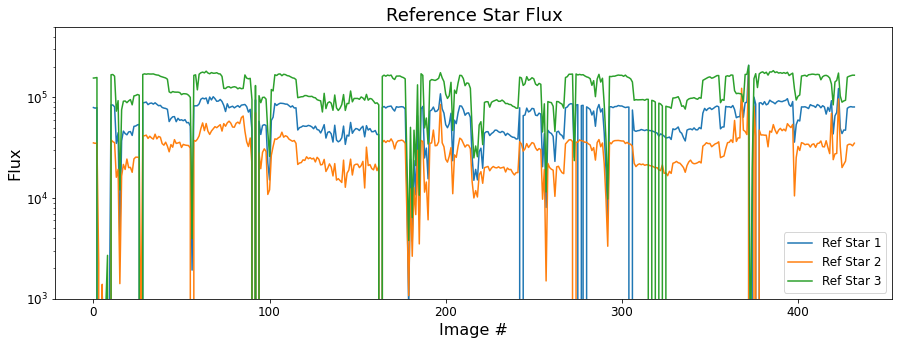

In [291]:
plt.figure(figsize = (15, 5))
for i in range(len(ref_stars)): 
    plt.plot(fluxes[i,:], label = f'Ref Star {i+1}')
plt.yscale('log')
plt.xlabel('Image #', size = 16)
plt.ylabel("Flux", size = 16)
plt.title("Reference Star Flux", size = 18)
plt.ylim(1e3, 5e5)
plt.legend()
plt.show()

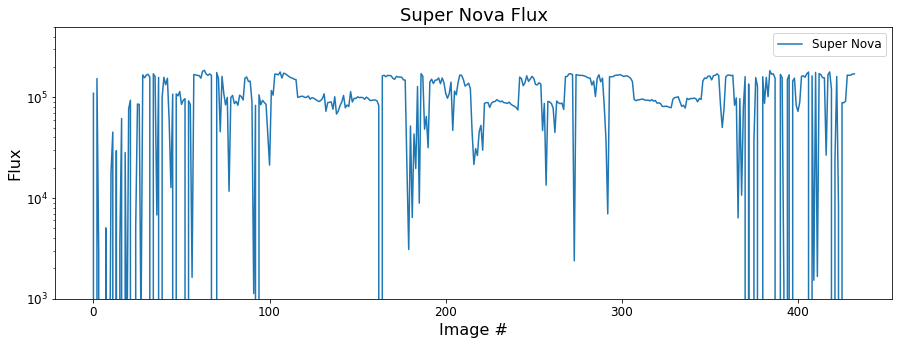

In [338]:
plt.figure(figsize = (15, 5))
#for i in range(len(ref_stars)): 
plt.plot(fluxes, label = 'Super Nova')
plt.yscale('log')
plt.xlabel('Image #', size = 16)
plt.ylabel("Flux", size = 16)
plt.title("Super Nova Flux", size = 18)
plt.ylim(1e3, 5e5)
plt.legend()
plt.show()

In [336]:
# lc of SN

#Repeating the code from above
boxsize = 15

# why is it 100 - boxsize? we are centering 100?

sub_im = data[100-boxsize: 100+boxsize+1, 100-boxsize: 100+boxsize+1]

#Create an aperture and annulus model
aperture = get_aperture(sub_im)
annulus = get_annulus(sub_im)

fluxes = np.empty(len(img_files))

for i, f in enumerate(img_files):
    
    data, header  = read_file(f)
   # print(np.shape(data))
    w = WCS(header)
    
    ref_x, ref_y = np.shape(data)[1] * 0.5, np.shape(data)[0] * 0.5
    #print('refrence ')
   # print(ref_x, ref_y)
    ref_x_int, ref_y_int = int(ref_y), int(ref_x)
    sub_im = data[ref_y_int-boxsize: ref_y_int+boxsize+1, 
                      ref_x_int-boxsize: ref_x_int+boxsize+1]
    sub_im = center_image(data, sub_im, ref_pos)
        
        #Get the flux for each of the reference stars 
    fluxes[i] = get_flux(sub_im, aperture, annulus)
        



my r  15
centroid location
1255 1756
centroid location
1286 1740
centroid location
1273 1752
centroid location
1274 1752
centroid location
1268 1768
centroid location
1227 1763
centroid location
1239 1747
centroid location
1295 1746
centroid location
1261 1741
centroid location
1259 1754
centroid location
1249 1746
centroid location
1276 1759
centroid location
1261 1726
centroid location
1263 1737
centroid location
1262 1728
centroid location
1263 1772
centroid location
1260 1742
centroid location
1282 1736
centroid location
1279 1748
centroid location
1267 1772
centroid location
1263 1742
centroid location
1259 1751
centroid location
1246 1738
centroid location
1284 1762
centroid location
1262 1730
centroid location
1275 1755
centroid location
1275 1751
centroid location
1305 1703
centroid location
1264 1749
centroid location
1265 1761
centroid location
1264 1748
centroid location
1269 1750
centroid location
1266 1740
centroid location
1260 1781
centroid location
1261 1758
centroid lo

centroid location
1265 1749
centroid location
1265 1748
centroid location
1264 1747
centroid location
1264 1749
centroid location
1265 1748
centroid location
1265 1747
centroid location
1264 1748
centroid location
1265 1748
centroid location
1264 1748
centroid location
1265 1748
centroid location
1264 1747
centroid location
1266 1748
centroid location
1264 1748
centroid location
1263 1748
centroid location
1265 1748
centroid location
1264 1748
centroid location
1264 1748
centroid location
1265 1747
centroid location
1265 1747
centroid location
1265 1748
centroid location
1265 1747
centroid location
1264 1747
centroid location
1265 1747
centroid location
1264 1748
centroid location
1264 1747
centroid location
1265 1749
centroid location
1265 1747
centroid location
1264 1748
centroid location
1265 1746
centroid location
1264 1747
centroid location
1265 1748
centroid location
1264 1747
centroid location
1263 1747
centroid location
1265 1748
centroid location
1264 1747
centroid location
12

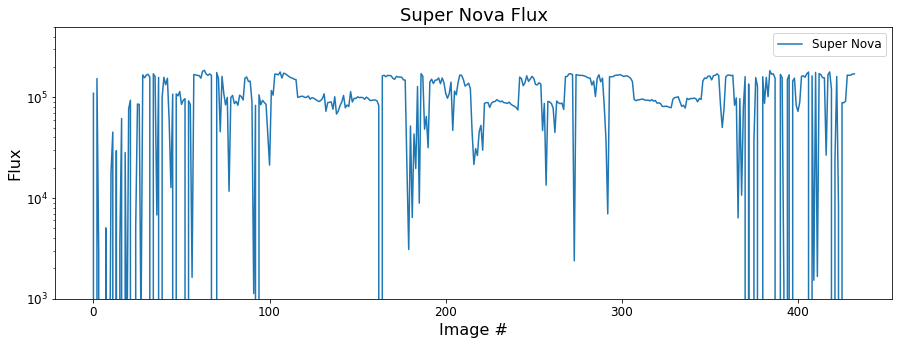

In [337]:
plt.figure(figsize = (15, 5))
#for i in range(len(ref_stars)): 
plt.plot(fluxes, label = 'Super Nova')
plt.yscale('log')
plt.xlabel('Image #', size = 16)
plt.ylabel("Flux", size = 16)
plt.title("Super Nova Flux", size = 18)
plt.ylim(1e3, 5e5)
plt.legend()
plt.show()

centroid location
1265 1748


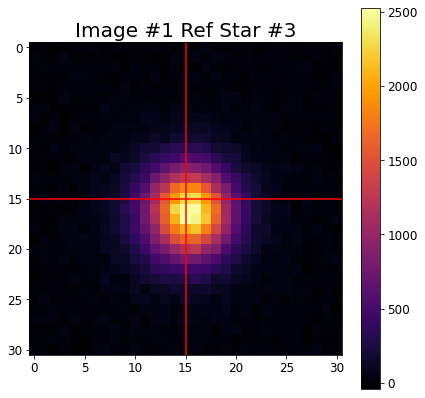

my r  15


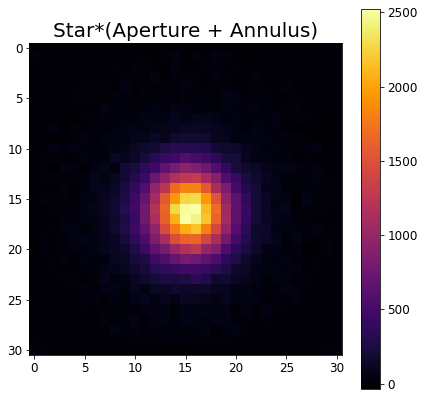

centroid location
1263 1748


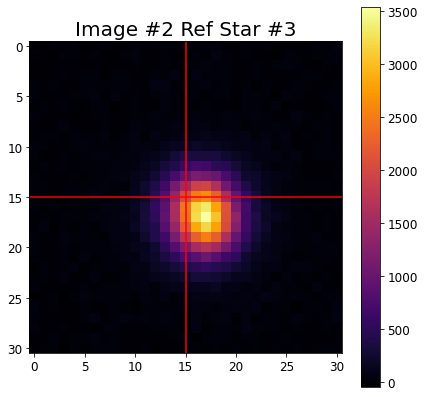

my r  15


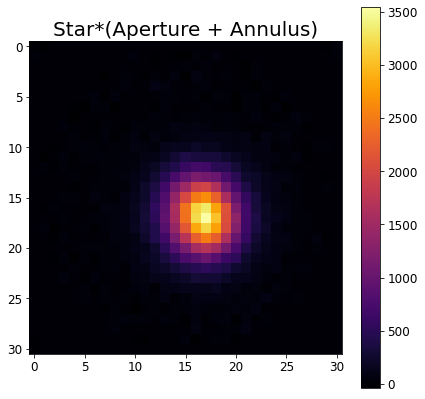

centroid location
1264 1749


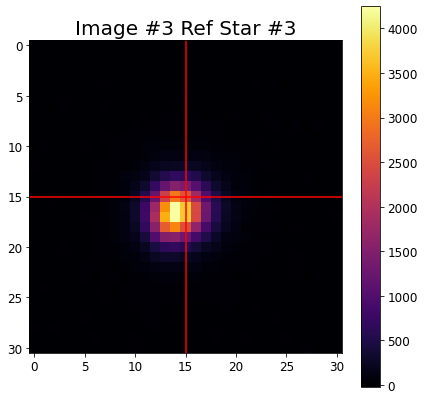

my r  15


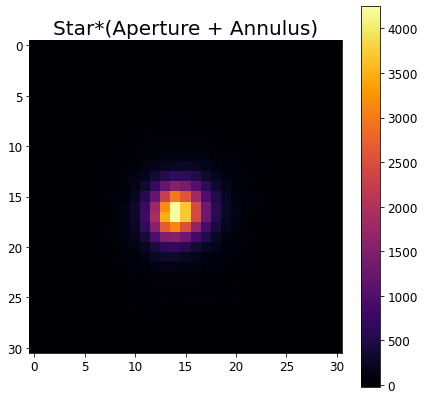

centroid location
1264 1747


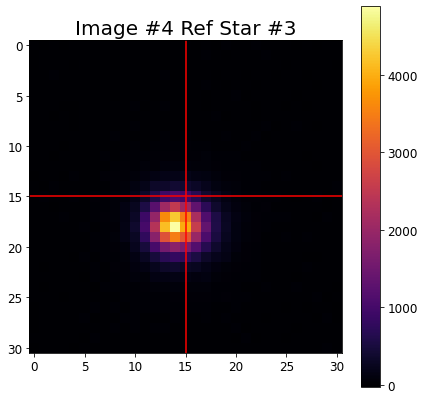

my r  15


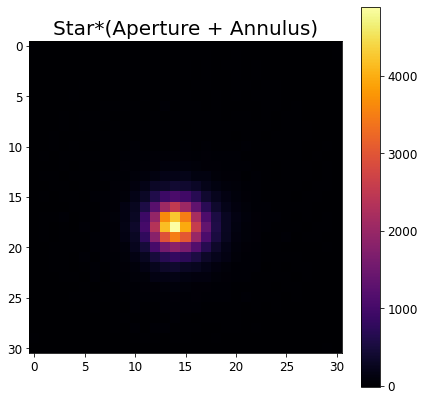

centroid location
1265 1746


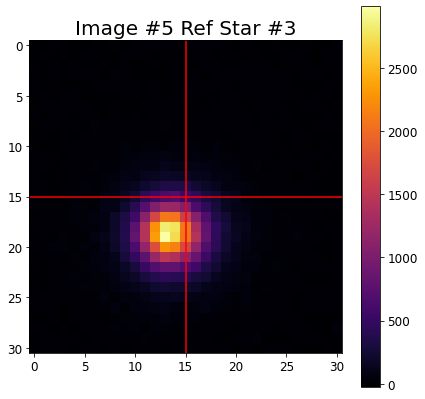

my r  15


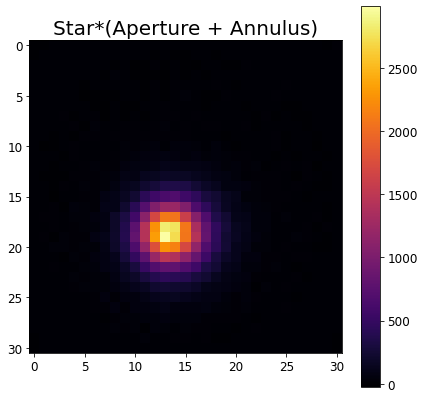

centroid location
1265 1750


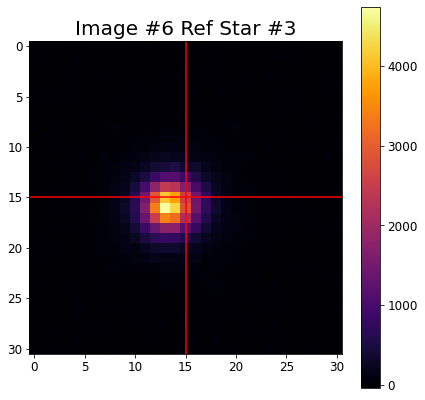

my r  15


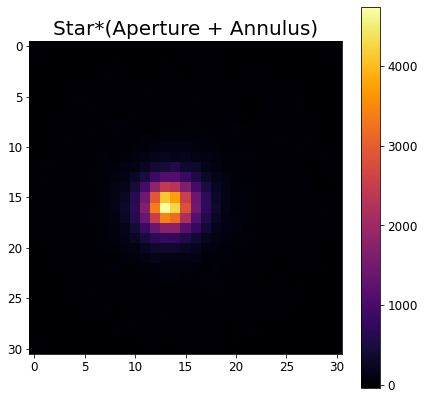

centroid location
1265 1747


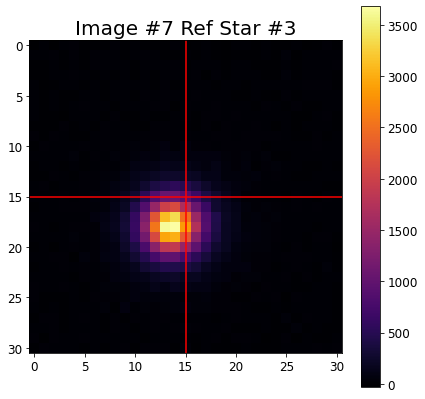

my r  15


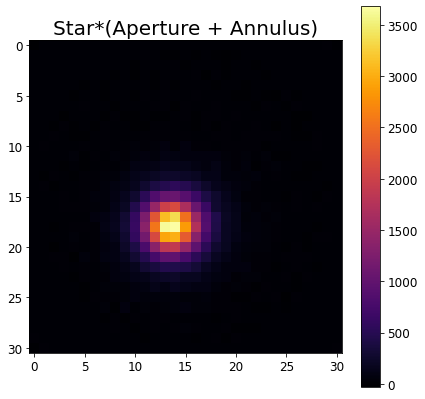

centroid location
1265 1748


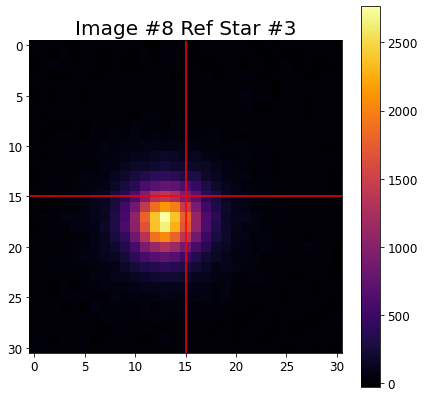

my r  15


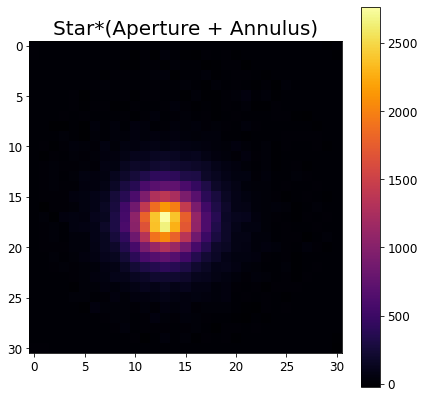

centroid location
1264 1749


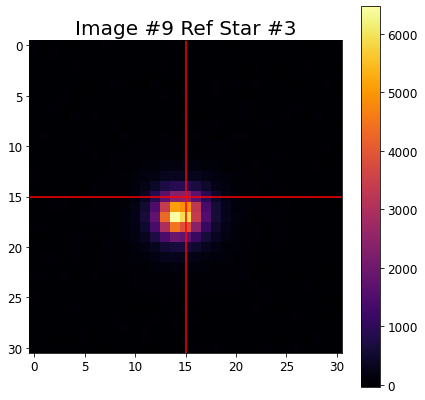

my r  15


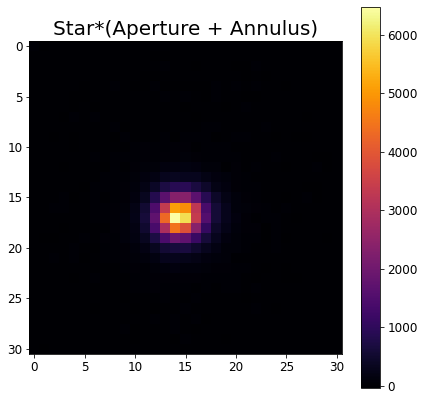

centroid location
1264 1748


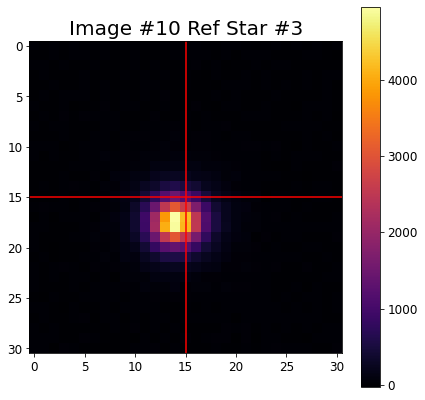

my r  15


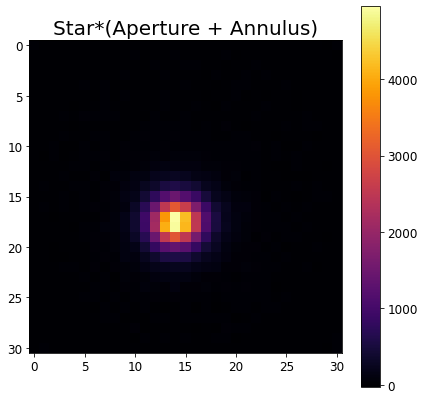

centroid location
1263 1751


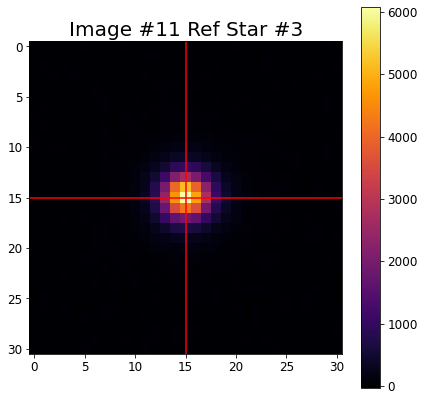

my r  15


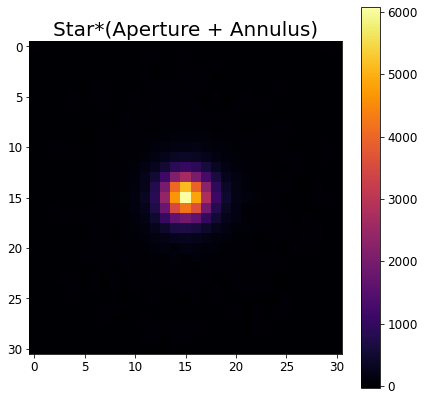

In [335]:
#Repeating the code from above
boxsize = 15

for i, f in enumerate(img_files[114:125]):
    
    data, header  = read_file(f)
    w = WCS(header)
    
 
    ref_x_int, ref_y_int = int(1125), int(1125)
    
    sub_im = data[ref_y_int-boxsize: ref_y_int+boxsize+1, 
                      ref_x_int-boxsize: ref_x_int+boxsize+1]
        

    centroid = my_centroid(sub_im)

    sub_im = center_image(data, sub_im, ref_pos)
  
    new_centroid = my_centroid(sub_im)
        #print("New Centroid", new_centroid)
        
    plt.figure(figsize=(7,7))
    plt.imshow(sub_im, cmap = 'inferno',interpolation = "None")
    plt.title(f"Image #{i+1} Ref Star #{j+1}", size = 20)
    plt.axvline(x = sub_im.shape[0]//2, color = 'red')
    plt.axhline(y = sub_im.shape[0]//2, color = 'red')
    plt.colorbar()
    plt.show()
        
    aperture = get_aperture(sub_im)
    annulus = get_annulus(sub_im)
        
    plt.figure(figsize=(7,7))
    plt.imshow(sub_im*(annulus + aperture), cmap = 'inferno',interpolation = "None")
    plt.title("Star*(Aperture + Annulus)", size = 20)
    plt.colorbar()
    plt.show()
    